Saving EEG Eye State.csv to EEG Eye State.csv
Number of run 1
Train loss 0.027673828793572726
Validation loss 0.11982495577456317
Train accuracy 0.9929906542056075
Validation accuracy 0.9579439250744869
Number of run 2
Train loss 0.026812461387609766
Validation loss 0.11578261696090686
Train accuracy 0.9919058746584903
Validation accuracy 0.961615487077685
Number of run 3
Train loss 0.031029737461233966
Validation loss 0.12784202741048684
Train accuracy 0.9900700935375228
Validation accuracy 0.9546061410445555
Number of run 4
Train loss 0.026889038076984867
Validation loss 0.11801217115410816
Train accuracy 0.9916555408005402
Validation accuracy 0.9569425896426864
Number of run 5
Train loss 0.028705961216435094
Validation loss 0.1361069696767626
Train accuracy 0.992489986808023
Validation accuracy 0.9536048064881237
Number of run 6
Train loss 0.028641720500106965
Validation loss 0.12041672626547566
Train accuracy 0.9919893192512808
Validation accuracy 0.9579439255519607
Number of run 7

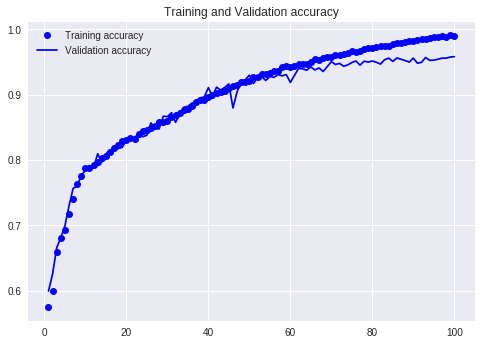

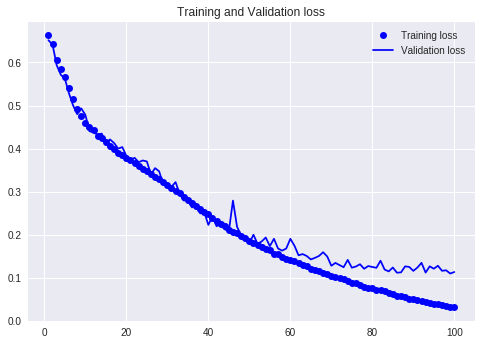

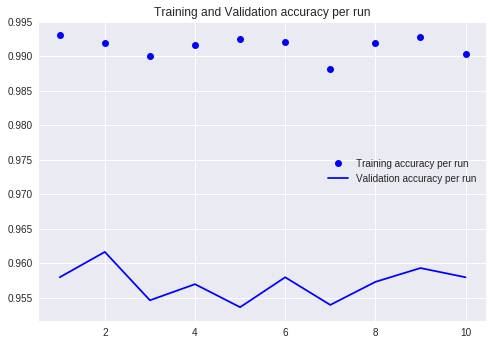

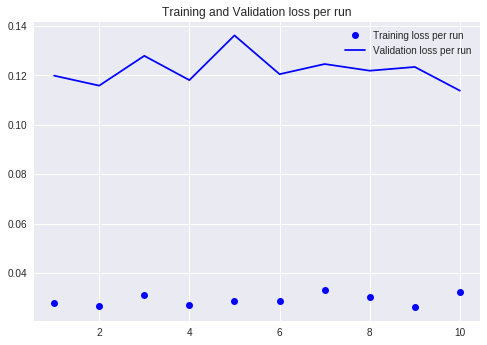

Average train loss 0.029136107751704228
Average train accuracy 0.9914218959327693
Average val loss 0.12214252677396716
Average val accuracy 0.9571094792579936


In [3]:

 #Eye State Prediction using Tensorflow Keras
!pip install -U -q PyDrive ## you will have install for every colab session
!pip install -q -U tensor2tensor ## Tensor Flow
!pip install -q tensorflow matplotlib ## Tensor Flow

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

from random import shuffle

import pandas as pd
import tensorflow as tf
import io
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, Dense, core,TimeDistributed,AveragePooling1D

from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from pandas import read_csv
from numpy import mean
from numpy import std
from numpy import delete
from numpy import savetxt


if __name__ == "__main__":
    
    uploaded = files.upload()
    file = io.StringIO(uploaded['EEG Eye State.csv'].decode('utf-8'))
    csv_file = pd.read_csv(file, sep=",",header=None)
    datalist = csv_file.values
    inputs = datalist[:, :-1]
    output = datalist[:, -1]

    num_runs = 10
    num_runs = num_runs + 1
    
    train_loss_list = []
    train_accuracy_list = []

    val_loss_list = []
    val_accuracy_list = []
      
    for run in range(1, num_runs) :
      
      #3 Use sklearn to shuffle and split into training input, output and test input and output
      Train_inputs, Test_inputs, train_output, test_output = train_test_split(inputs, output, test_size=0.20, shuffle=True, random_state=1)

      std_scale = preprocessing.StandardScaler().fit(Train_inputs)
      train_inputs = std_scale.transform(Train_inputs)
      test_inputs = std_scale.transform(Test_inputs)


      #4 Convert the training input and output numpy.ndarray to tensorflow object
      train_inputs_tf = tf.convert_to_tensor(train_inputs, np.float32)
      train_output_tf = tf.convert_to_tensor(train_output, np.float32)

      #5 Convert the test input and output numpy.ndarray to tensorflow object
      test_inputs_tf = tf.convert_to_tensor(test_inputs, np.float32)
      test_output_tf = tf.convert_to_tensor(train_output,np.float32)

      train_inputs_tf = train_inputs.reshape(11984,1,14)
      test_inputs_tf = test_inputs.reshape(2996,1,14)
      train_output_tf = train_output.reshape(11984,1,1)
      test_output_tf = test_output.reshape(2996,1,1)

      batch_size = 1
      training_split = 0.25
      num_fields = 14

      model = Sequential()
      model.add(LSTM(1024,return_sequences=True,implementation=2))
      model.add(Dropout(0.5))
      model.add(LSTM(1024,return_sequences=True,implementation=2))
      model.add(Dropout(0.5))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
      
      history = model.fit(train_inputs_tf, train_output_tf, epochs=100, batch_size= 128,verbose=0,validation_data=(test_inputs_tf, test_output_tf))

      loss = history.history['loss']
      val_loss = history.history['val_loss']
      
      train_loss_list.append(loss[-1])
      val_loss_list.append(val_loss[-1])
      
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      epoch = range(1,len(loss)+1)
      
      train_accuracy_list.append(acc[-1])
      val_accuracy_list.append(val_acc[-1])
      
      print("Number of run " + str(run))
      print("Train loss " + loss[-1].astype(str))
      print("Validation loss " + val_loss[-1].astype(str))
      print("Train accuracy " + acc[-1].astype(str))
      print("Validation accuracy " + val_acc[-1].astype(str))
      
      if run >= (num_runs - 1) : 
        x_val = [x for x in range(1, 101)]
        plt.figure()
        plt.plot(x_val, acc,'bo', label= 'Training accuracy')
        plt.plot(x_val, val_acc,'b', label= 'Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(x_val, loss,'bo', label= 'Training loss')
        plt.plot(x_val, val_loss,'b', label= 'Validation loss')
        plt.title('Training and Validation loss')
        plt.legend()
        plt.show()
    
    x_values = [x for x in range(1, num_runs)]
        
    plt.figure()
    plt.plot(x_values,train_accuracy_list,'bo',label= 'Training accuracy per run')
    plt.plot(x_values,val_accuracy_list,'b',label= 'Validation accuracy per run')
    plt.title('Training and Validation accuracy per run')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(x_values,train_loss_list,'bo',label= 'Training loss per run')
    plt.plot(x_values,val_loss_list,'b',label= 'Validation loss per run')
    plt.title('Training and Validation loss per run')
    plt.legend()
    plt.show()
    
    average_train_loss = sum(train_loss_list, 0.0)/len(train_loss_list)
    average_train_accuracy = sum(train_accuracy_list, 0.0)/len(train_accuracy_list)
    print("Average train loss " + average_train_loss.astype(str))
    print("Average train accuracy " + average_train_accuracy.astype(str))
    
    average_val_loss = sum(val_loss_list, 0.0)/len(val_loss_list)
    average_val_accuracy = sum(val_accuracy_list, 0.0)/len(val_accuracy_list)
    print("Average val loss " + average_val_loss.astype(str))
    print("Average val accuracy " + average_val_accuracy.astype(str))
    